# S-EPGP demo

## Imports, etc

In [1]:
## Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pde import CartesianGrid, solve_laplace_equation

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_dtype(torch.float64)
torch.manual_seed(13);

## True solution

We compute a numerical solution to the Laplace equation in 2D: $\partial_x^2 + \partial_y^2 = 0$.

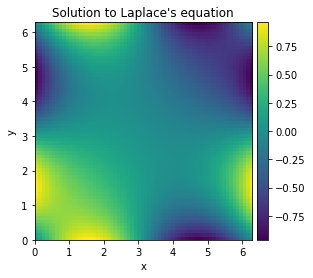

In [2]:
grid = CartesianGrid([[0, 2 * np.pi]] * 2, 64)
bcs = [{"value": "sin(y)"}, {"value": "sin(x)"}]

res = solve_laplace_equation(grid, bcs)
res.plot();

We convert the `py-pde` types to PyTorch tensors

In [3]:
Ps = torch.tensor(grid.cell_coords)
u_true = torch.tensor(res.data)

Learning data will consist of randomly sampled points in the numerical solution

In [4]:
train_pts = 50
train_idx = torch.randperm(len(u_true.flatten()))[:train_pts]
X = Ps.flatten(0,1)[train_idx]
U = u_true.flatten()[train_idx]

## Setting up a S-EPGP kernel

Running the command `solvePDE` in Macaulay2 reveals two varieties, namely the lines $ a = i b$ and $a = - i b$, where $a,b$ are spectral variables corresponding to $x,y$ respectively. For both lines, there is only one Noetherian multiplier, namely 1. This means that the Ehrenpreis-Palamodov representation of solutions to Laplace's equations are of the form
$$
\int_{a = ib} e^{ax + by} \, d\mu_1(a,b) + \int_{a=-ib} e^{ax + by} \, d\mu_2(a,b)
$$

By parametrizing the two lines, we can rewrite the integrals in a simpler form.
We use the parametrizations
$$ (a,b) = ((1+i)c, (1-i)c) \\ (a,b) = ((1-i)c, (1+i)c) $$

The integrals then become
$$
\int_{\mathbb C} e^{(1+i)cx + (1-i)cy} \, d\mu_1'(c) + \int_{\mathbb C} e^{(1-i)cx + (1+i)cy} \, d\mu_2'(c)
$$

We approximate each measure with $m$ Dirac delta measures. This translates to the S-EPGP kernel
$$ k(x,y) = \Phi(x,y)^H \Sigma \Phi(x,y), $$
where $\Phi(x,y)$ is the vector with entries
$$ 
\Phi(x,y)_j = \begin{cases} e^{(1+i)c_jx + (1-i)c_jy}, & \text{if } j = 1,\dotsc,m \\ e^{(1-i)c_jx + (1+i)c_jy}, & \text{if } j = m+1, \dotsc, 2m \end{cases},
$$
and $\Sigma$ is a $2m \times 2m$ diagonal matrix with positive entries $\sigma_j^2$.

Our goal will be to learn the $c_j \in \mathbb C, \sigma_j^2 > 0$ that minimize the log-marginal likelihood.

Given an array `c` of length `2m` and a `s × 2` matrix `X` of points `(x,y)`, the function `Phi` returns the `2m × s` matrix with columns $\Phi(x,y)$.

In [5]:
def Phi(c,X):
    c1, c2 = c.chunk(2)
    c1 = c1.unsqueeze(1) * torch.tensor([1+1.j,1-1.j])
    c2 = c2.unsqueeze(1) * torch.tensor([1-1.j,1+1.j])
    cc = torch.cat([c1,c2])
    return cc.inner(X).exp()

## Objective function

Suppose we are trying to learn on $s$ data points.
Let $X$ be the $s \times 2$ matrix with input points $x_k, y_k$, and $U$ the $s \times 1$ vector with output values $u_k$.
Let $\Phi$ be the $2m \times s$ matrix of features obtained by the function `Phi` above.

The negative log-marginal likelihood function is
$$
\frac{1}{2\sigma_0^2}(U^TU - U^T\Phi^HA^{-1}\Phi U) + \frac{s - 2m}{2} \log \sigma_0^2 + \frac{1}{2} \log |A| + \frac{1}{2} \log |\Sigma| + \frac{n}{2} \log 2\pi,
$$
where $\sigma_0^2$ is a noise coefficient, and
$$ A = \Phi \Phi^H + \sigma_0^2 \Sigma^{-1} $$

This can be computed efficiently using a Cholesky decomposition: $A = LL^H$. Ignoring constants and exploiting the structure of $\Sigma$, we get the objective function
$$
\frac{1}{2\sigma^2}(\|U\|^2 - \|L^{-1}\Phi U\|^2) + \frac{s-2m}{2} \log \sigma_0^2 + \sum_{j=1}^{2m} \log L_{j,j} + \frac{1}{2} \sum_{j=1}^{2m} \log \sigma_j^2
$$

The function below computes the Negative Log-Marginal Likelihood (NLML). Here we assume that `Sigma` is a length $2m$ vector of values $\log \sigma_j^2$, and `sigma0` is $\log \sigma_0^2$

In [6]:
def NLML(X,U,c,Sigma,sigma0):
    phi = Phi(c,X)
    A = phi @ phi.H + torch.diag_embed((sigma0-Sigma).exp())
    L = torch.linalg.cholesky(A)
    alpha = torch.linalg.solve_triangular(L, phi @ U, upper=False)
    nlml = 1/(2*sigma0.exp()) * (U.norm().square() - alpha.norm().square())
    nlml += (phi.shape[1] - phi.shape[0])/2 * sigma0
    nlml += L.diag().real.log().sum()
    nlml += 1/2 * Sigma.sum()
    return nlml

## Training

We now set up parameters, initial values, optimizers and the training routine. We will use $m = 8$ Dirac delta measures for each integral.

In [7]:
m = 8
Sigma = torch.full((2*m,), -np.log(2*m)).requires_grad_()
sigma0 = torch.tensor(np.log(1e-5)).requires_grad_()
c = (1*torch.randn(2*m, dtype=torch.complex128)).requires_grad_()

U = U.to(torch.complex128).reshape(-1,1)
X = X.to(torch.complex128)

In [8]:
def train(opt, sched, epoch_max = 1000):
    for epoch in range(epoch_max):
        nlml = NLML(X,U,c,Sigma,sigma0)

        print(f'Epoch {epoch+1}/{epoch_max}\tNLML {nlml.detach():.3f}\tsigma0 {sigma0.exp():.3}\tc std {c.std():.3f}\tlr {sched.get_last_lr()[0]}', end='\r')

        opt.zero_grad()
        nlml.backward()
        opt.step()
        sched.step()

Here we use a simple Adam optimizer, with learning rate 0.1, and decaying by a factor of 10 every 1000 steps.
We train for 3000 epochs.

In [9]:
opt = torch.optim.Adam([c,Sigma,sigma0], lr = 1e-2)
sched = torch.optim.lr_scheduler.StepLR(opt,3000,gamma=0.1)
train(opt,sched,3000)

## Prediction

Suppose we want to use our trained model to predict the value of the function at $r$ points $(x,y)$, organized in the $r \times 2$ matrix $X_*$. 
We will do inference using the posterior mean, which is given by
$$
\Phi_*^H A^{-1} \Phi U,
$$
where $\Phi_*$ is the $2m \times r$ matrix, with columns $\Phi(x,y)$ for each row in $X_*$.

The following function computes the prediction, where the variable `X_` corresponds to $X_*$

In [10]:
def predict(X_, X,U,c,Sigma,sigma0):
    with torch.no_grad():
        phi = Phi(c,X)
        A = phi @ phi.H + torch.diag_embed((sigma0-Sigma).exp())
        L = torch.linalg.cholesky(A)

        alpha = torch.linalg.solve_triangular(L, phi @ U, upper=False)
        alpha1 = torch.linalg.solve_triangular(L.H, alpha, upper=True)

        phi_ = Phi(c,X_)
        return (phi_.H @ alpha1).real    

In [11]:
X_ = Ps.flatten(0,1).to(torch.complex128)
u_pred = predict(X_, X, U, c, Sigma, sigma0)

The root mean square error of our prediction is below

In [12]:
(u_pred.view_as(u_true) - u_true).square().mean().sqrt().item()

0.0003669123836532972

We can also visually compare the true solution with our prediction.

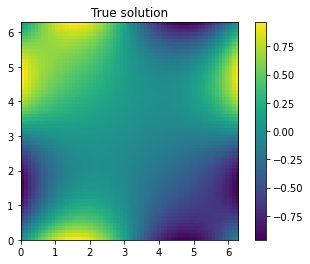

In [13]:
ax = plt.imshow(u_true,extent=2*[0,2*np.pi])
plt.colorbar(ax)
plt.title("True solution");

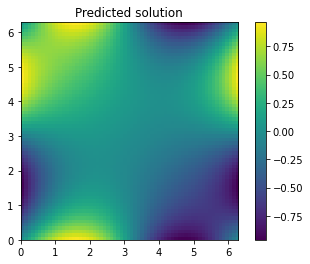

In [14]:
ax = plt.imshow(u_pred.view_as(u_true),extent=2*[0,2*np.pi])
plt.colorbar(ax)
plt.title("Predicted solution");

Finally, we plot the difference between the true and predicted solutions

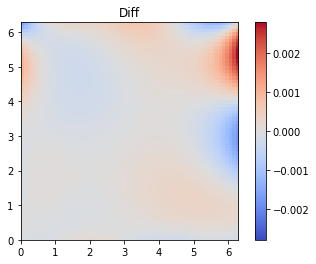

In [15]:
diff = u_pred.view_as(u_true) - u_true
limit = max(diff.max(), -diff.min())
ax = plt.imshow(diff,extent=2*[0,2*np.pi], cmap='coolwarm', vmin = -limit, vmax = limit)
plt.colorbar(ax)
plt.title("Diff");